In [1]:
# required Python imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from scipy.stats import bayes_mvs, norm, iqr

In [2]:
# Set Nature-like plots
import matplotlib as mpl
# Figure size
mpl.rcParams['figure.figsize'] = 6.2, 5.0
# Set x axis
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.top'] = True
# Set y axis
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
# Font sizes
mpl.rcParams['axes.labelsize'] = 19
mpl.rcParams['xtick.labelsize'] = 17
mpl.rcParams['ytick.labelsize'] = 17
mpl.rcParams['legend.fontsize'] = 17
mpl.rcParams['font.size'] = 17
# Font Family
#mpl.rcParams['font.family'] = 'Open Sans'
# Set line widths
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['grid.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['lines.markersize'] = 12
# Remove legend frame
mpl.rcParams['legend.frameon'] = False

In [3]:
dataset = pd.read_csv('output/2024-03-22_lamb1987_step7_guesses.csv')
dataset

,Euler1,Euler2,Euler3,default10,default15,default20,default25,default30
0,0,0,0,0.279,0.000,0.000,0.000,0.242
1,0,0,7,0.000,0.000,0.000,0.000,0.000
2,0,0,14,0.387,0.000,0.278,0.000,0.000
3,0,0,21,0.058,0.272,0.281,0.204,0.000
4,0,0,28,0.264,0.247,0.000,0.000,0.314
...,...,...,...,...,...,...,...,...
4389,84,84,147,0.014,0.015,0.012,0.013,0.011
4390,84,84,154,0.015,0.011,0.013,0.012,0.011
4391,84,84,161,6.196,0.007,0.006,0.008,0.011
4392,84,84,168,6.161,6.118,0.010,0.009,0.008


In [4]:
dataset[['default10', 'default15', 'default20', 'default25', 'default30']].describe()

,default10,default15,default20,default25,default30
count,4394.000000,4394.00000,4394.000000,4394.000000,4394.000000
mean,0.116961,0.04961,0.032145,0.026046,0.023646
std,0.899723,0.27505,0.148825,0.093116,0.074087
min,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.003000,0.00300,0.003000,0.003000,0.003000
50%,0.005000,0.00500,0.004000,0.004000,0.004000
75%,0.013000,0.01100,0.011000,0.010000,0.009000
max,30.889000,6.67000,4.746000,2.429000,1.524000


## Visualize distributions

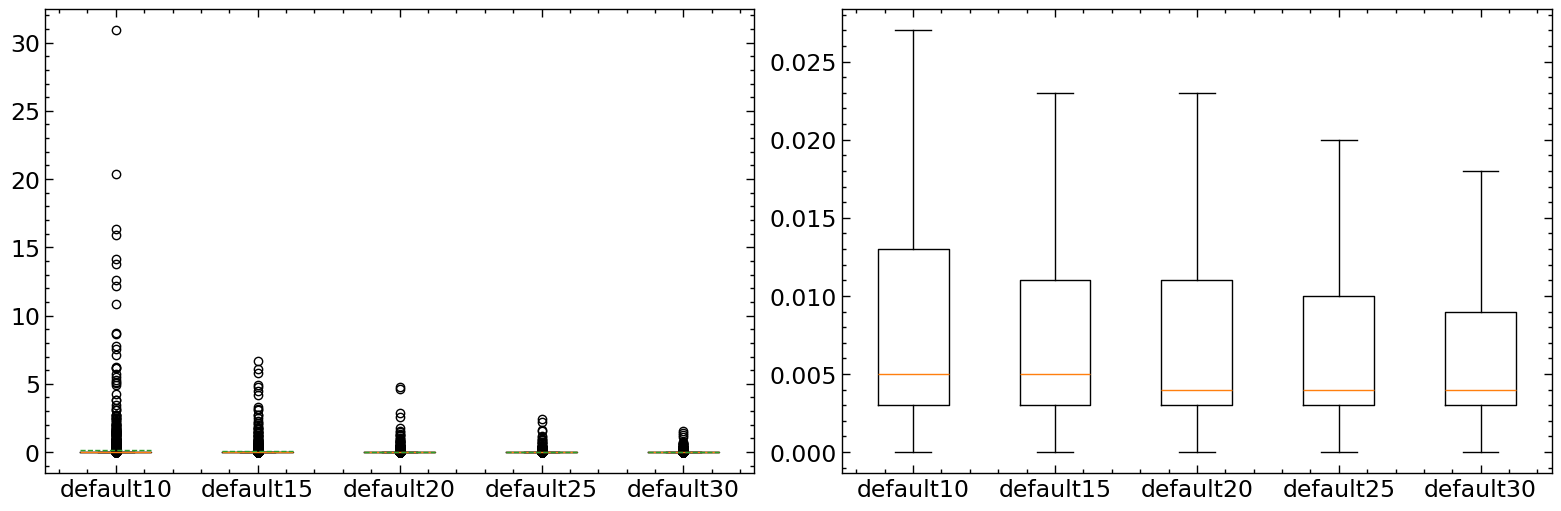

In [5]:
labels = ['default10', 'default15', 'default20', 'default25', 'default30']

fig1, (ax1, ax2) = plt.subplots(ncols=2, figsize=(5*3.1,5), constrained_layout=True)

ax1.boxplot(dataset[['default10', 'default15', 'default20', 'default25', 'default30']], meanline=True, showmeans=True, labels=labels)
_ = ax2.boxplot(dataset[['default10', 'default15', 'default20', 'default25', 'default30']], showfliers=False, labels=labels)


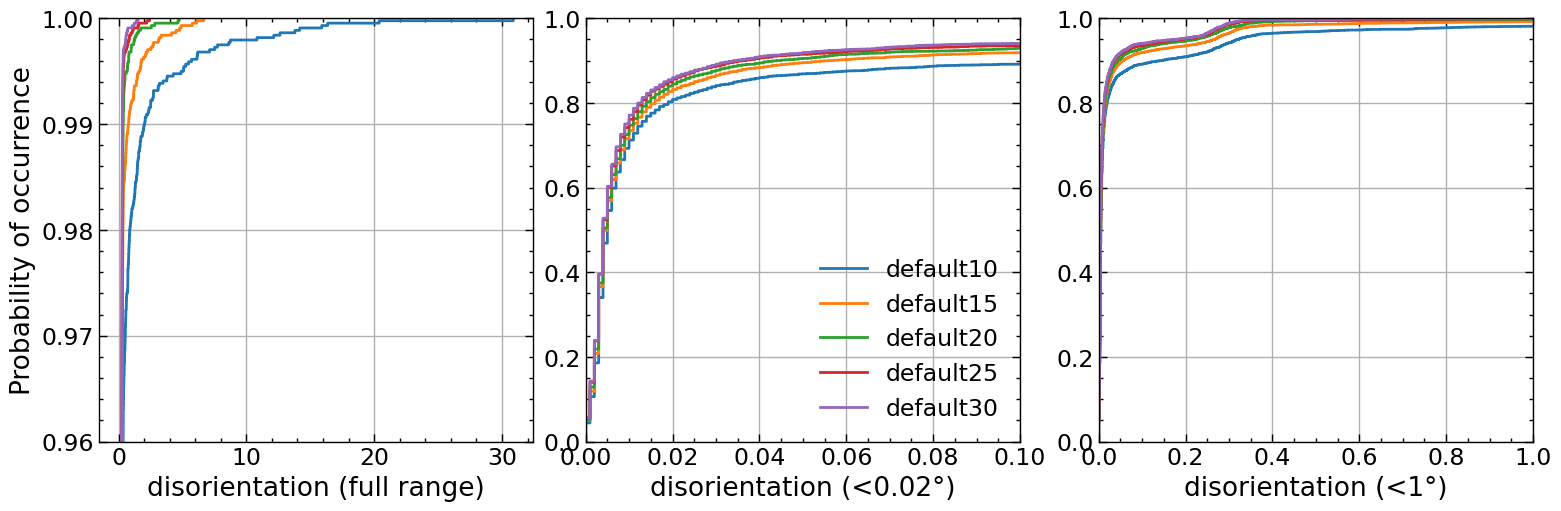

In [6]:
fig2, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(5*3.1, 5), constrained_layout=True)

ax1.ecdf(dataset['default10'], label='default10')
ax1.ecdf(dataset['default15'], label='default15')
ax1.ecdf(dataset['default20'], label='default20')
ax1.ecdf(dataset['default25'], label='default25')
ax1.ecdf(dataset['default30'], label='default30')
# ax1.set_xlim(left=1)
ax1.set_ylim(bottom=0.96)
ax1.grid(True)
ax1.set_xlabel('disorientation (full range)')
ax1.set_ylabel("Probability of occurrence")

ax2.ecdf(dataset['default10'], label='default10')
ax2.ecdf(dataset['default15'], label='default15')
ax2.ecdf(dataset['default20'], label='default20')
ax2.ecdf(dataset['default25'], label='default25')
ax2.ecdf(dataset['default30'], label='default30')
ax2.set_xlim(left=0, right=0.1)
ax2.grid(True)
ax2.set_xlabel('disorientation (<0.02°)')
ax2.legend(loc='best')

ax3.ecdf(dataset['default10'], label='default10')
ax3.ecdf(dataset['default15'], label='default15')
ax3.ecdf(dataset['default20'], label='default20')
ax3.ecdf(dataset['default25'], label='default25')
ax3.ecdf(dataset['default30'], label='default30')
ax3.set_xlim(left=0, right=1)
ax3.set_xlabel('disorientation (<1°)')
_ = ax3.grid(True)

In [7]:
def median_ci(pop, n, ci=0.95):
    """ Estimate the approximate ci 95% error margins for the median
    using a rule of thumb based on Hollander and Wolfe (1999).
    """

    z_score = norm.ppf(1 - (1 - ci) / 2)  # two-tailed z score

    id_upper = 1 + (n / 2) + (z_score * np.sqrt(n)) / 2
    id_lower = (n / 2) - (z_score * np.sqrt(n)) / 2

    if int(np.ceil(id_upper)) >= len(pop):
        upper_ci, lower_ci = pop[-1], pop[int(np.floor(id_lower))]
    else:
        upper_ci, lower_ci = pop[int(np.ceil(id_upper))], pop[int(np.floor(id_lower))]
    interval = upper_ci - lower_ci

    return (lower_ci, upper_ci), interval

def median(pop, ci=0.95):
    """ Returns the median, the interquartile length, and the confidence
    intervals for the median based on th rule-of-thumb method of Hollander
    and Wolfe (1999).
    """
    pop, n = np.sort(pop), len(pop)
    median, iqr_range = np.median(pop), iqr(pop)

    # compute confidence intervals
    ci_limits, length = median_ci(pop, n, ci)

    return median, iqr_range, ci_limits, length

In [8]:
mid_default10, iqr_default10, ci_default10, length_default10 = median(dataset['default10'])
mid_default15, iqr_default15, ci_default15, length_default15 = median(dataset['default15'])
mid_default20, iqr_default20, ci_default20, length_default20 = median(dataset['default20'])
mid_default25, iqr_default25, ci_default25, length_default25 = median(dataset['default25'])
mid_default30, iqr_default30, ci_default30, length_default30 = median(dataset['default30'])

print('EVALUATION OF ALGORITHMS USING DISORIENTATION IN DEGREES (ROBUST APPROACH)')
print('')
print('Default algorithm (10 guesses)')
print(f'Median: {mid_default10:.3f}; min,max: {ci_default10}')
print(f'   IQR: {iqr_default10:.3f}; length: {length_default10:.3f}')
print('')
print('Default algorithm (15 guesses)')
print(f'Median: {mid_default15:.3f}; min,max: {ci_default15}')
print(f'   IQR: {iqr_default15:.3f}; length: {length_default15:.3f}')
print('')
print('Default algorithm (20 guesses)')
print(f'Median: {mid_default20:.3f}; min,max: {ci_default20}')
print(f'   IQR: {iqr_default20:.3f}; length: {length_default20:.3f}')
print('')
print('Default algorithm (25 guesses)')
print(f'Median: {mid_default25:.3f}; min,max: {ci_default25}')
print(f'   IQR: {iqr_default25:.3f}; length: {length_default25:.3f}')
print('')
print('Default algorithm (30 guesses)')
print(f'Median: {mid_default30:.3f}; min,max: {ci_default30}')
print(f'   IQR: {iqr_default30:.3f}; length: {length_default30:.3f}')
print('')

EVALUATION OF ALGORITHMS USING DISORIENTATION IN DEGREES (ROBUST APPROACH)

Default algorithm (10 guesses)
Median: 0.005; min,max: (0.005, 0.005)
   IQR: 0.010; length: 0.000

Default algorithm (15 guesses)
Median: 0.005; min,max: (0.004, 0.005)
   IQR: 0.008; length: 0.001

Default algorithm (20 guesses)
Median: 0.004; min,max: (0.004, 0.005)
   IQR: 0.008; length: 0.001

Default algorithm (25 guesses)
Median: 0.004; min,max: (0.004, 0.004)
   IQR: 0.007; length: 0.000

Default algorithm (30 guesses)
Median: 0.004; min,max: (0.004, 0.004)
   IQR: 0.006; length: 0.000



## Percent of wrong estimates

In [9]:
print('Wrong estimates:')
print(f"Percent above 1 degree (10 guesses): {100 * (dataset['default10'] > 1).mean():.2f} %")
print(f"Percent above 1 degree (15 guesses): {100 * (dataset['default15'] > 1).mean():.2f} %")
print(f"Percent above 1 degree (20 guesses): {100 * (dataset['default20'] > 1).mean():.2f} %")
print(f"Percent above 1 degree (25 guesses): {100 * (dataset['default25'] > 1).mean():.2f} %")
print(f"Percent above 1 degree (30 guesses):  {100 * (dataset['default30'] > 1).mean():.2f} %")


Wrong estimates:
Percent above 1 degree (10 guesses): 1.87 %
Percent above 1 degree (15 guesses): 0.80 %
Percent above 1 degree (20 guesses): 0.27 %
Percent above 1 degree (25 guesses): 0.14 %
Percent above 1 degree (30 guesses):  0.09 %


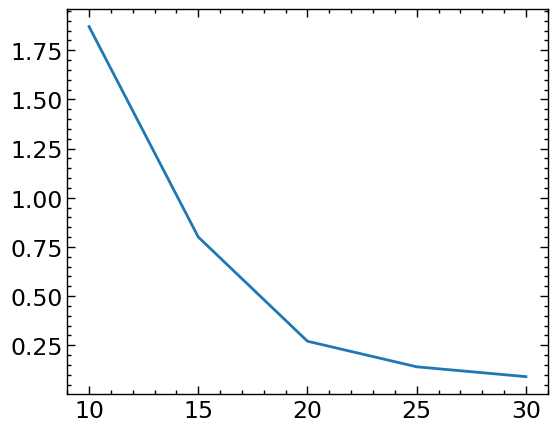

In [10]:
plt.plot([10, 15, 20, 25, 30], [1.87, 0.80, 0.27, 0.14, 0.09])

## Others

In [11]:
dataset[dataset['default30'] > 1]

,Euler1,Euler2,Euler3,default10,default15,default20,default25,default30
3409,70,7,21,0.005,4.498,0.084,0.003,1.524
3767,77,7,161,0.272,0.714,0.349,0.011,1.394
3768,77,7,168,1.575,0.316,0.026,0.766,1.068
3795,77,14,175,0.005,0.004,0.007,0.005,1.223


In [12]:
dataset[dataset['default20'] > 1]

,Euler1,Euler2,Euler3,default10,default15,default20,default25,default30
106,0,28,14,3.109,0.015,1.262,0.036,0.001
707,14,7,35,0.157,0.002,1.189,0.272,0.002
721,14,7,133,0.009,0.171,1.727,0.004,0.000
1743,35,14,7,0.005,0.004,2.569,0.001,0.003
2395,49,7,21,1.400,0.030,2.837,0.001,0.004
2750,56,7,140,0.558,0.817,1.010,0.003,0.004
3072,63,7,28,0.004,0.829,1.441,0.032,0.010
3083,63,7,105,0.039,0.003,1.218,0.022,0.007
3457,70,14,175,0.091,0.174,1.569,0.024,0.241
3639,70,63,175,0.006,0.006,4.648,0.006,0.006


In [13]:
# check if all the algorithms failed
dataset.query('default10 > 1 and default20 > 1 and default30 > 1')

,Euler1,Euler2,Euler3,default10,default15,default20,default25,default30
